How much could sparse timesteps save us?
-------------------------------------

Let us generate a simple version of a gravity sim, with one planetary body and one object in orbit. We use a simple algorithm to save simulation points when the deviation between the actual trajectory and the interpolated one exceeds a fixed threshold. We compare the size of this adaptive data with the number of original data points


In [1]:
import numpy as np
import numpy.linalg as ln
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
class Body:
    def __init__(self, _mass, _pos, _vel):
        self.mass = _mass
        self.pos = _pos
        self.vel = _vel
        self.acc = None
    
    def update(self, dt):
        self.vel += self.acc * dt
        self.pos += self.vel * dt

        
def acc_ab(a, b):
    r = a.pos - b.pos
    r2 = np.dot(r, r)
    d = r / ln.norm(r)
    Fb = d * (a.mass * b.mass) / r2
    Fa = -Fb
    a.acc = Fa / a.mass
    b.acc = Fb / b.mass
    
        
def sim_step(a, b, dt):
    acc_ab(a, b)
    a.update(dt)
    b.update(dt)

In [58]:
planet = Body(1000, np.array([0.0, 0.0, 0.0]), np.array([1.0, 0.0, 0.0]))
ship = Body(1, np.array([0.0, 10.0, 0.0]), np.array([10.0, 0.0, 0.0]))

In [59]:
N = 100000
dt = 1e-3

ship_pos = np.empty((N, 3), dtype=float)
for n in range(N):
    sim_step(planet, ship, dt)
    ship_pos[n, :] = ship.pos

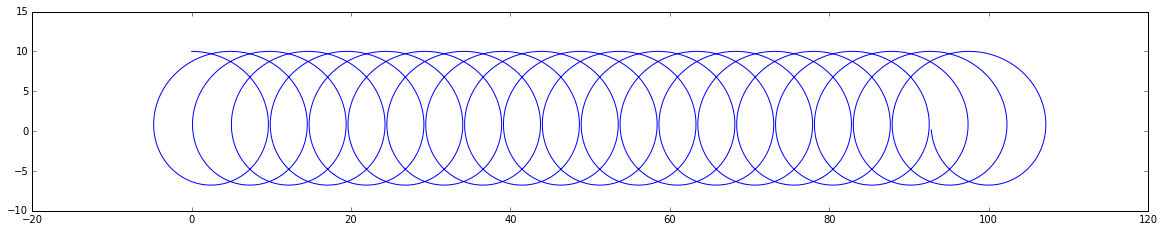

In [136]:
plt.figure(figsize=(20,10))
plt.plot(ship_pos[:, 0], ship_pos[:, 1])
_ = plt.axis('scaled')

In [123]:
def perp_dist(x, y, z):
    """x, z are endpoints, y is a point on the curve"""
    a = y - x
    a2 = np.dot(a, a)
    b = y - z
    b2 = np.dot(b, b)
    l = z - x
    l2 = np.dot(l, l)
    l = l2**0.5
    return (a2 - ((l2 + a2 - b2)/(2*l))**2)**0.5

# Here we'll compute the value for each point, but using just the mid point is probably 
# a pretty good heurstic
def max_dist(pos, n0, n1):
    return np.array([perp_dist(pos[n0, :], pos[n2, :], pos[n1, :]) for n2 in range(n0, n1)]).max()

# Here we'll just use the midpoint for speed
def mid_dist(pos, n0, n1):
    return perp_dist(pos[n0, :], pos[int((n1 + n0)/2), :], pos[n1, :])
    

def adaptive_save(pos, thresh=0.1):
    adaptive_pos = [pos[0, :]]
    last_n = 0
    for n in range(1, pos.shape[0]):
        #print(pos[last_n,:])
        if n == last_n: continue
        #print(pos[n, :])
        if mid_dist(pos, last_n, n) > thresh:
            adaptive_pos.append(pos[n - 1, :])
            last_n = n - 1
    return np.vstack(adaptive_pos)

In [128]:
a_pos = adaptive_save(ship_pos, thresh=.1)

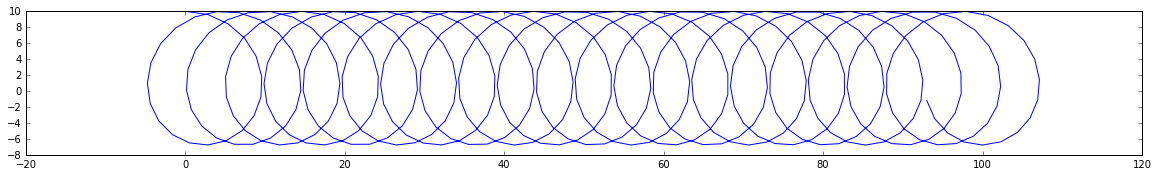

In [135]:
plt.figure(figsize=(20,10))
plt.plot(a_pos[:, 0], a_pos[:, 1])
_ = plt.axis('scaled')

In [137]:
100 * a_pos.shape[0] / N


0.422

Not too shabby! The interpolated trace looks good and we only need 0.4% of the points! If we think the lines are too edgy, we can dial down the threshold further ...

In [138]:
a_pos2 = adaptive_save(ship_pos, thresh=.01)

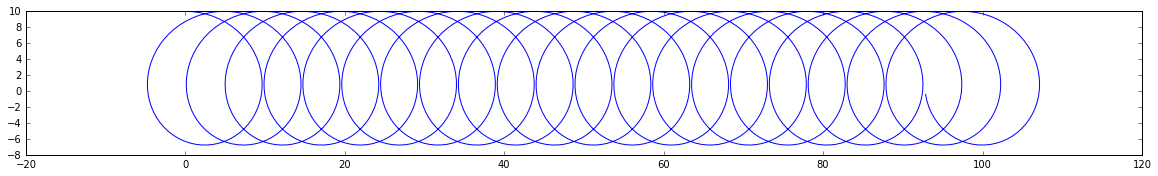

In [139]:
plt.figure(figsize=(20,10))
plt.plot(a_pos2[:, 0], a_pos2[:, 1])
_ = plt.axis('scaled')

In [140]:
100 * a_pos2.shape[0] / N


1.341

Still we are only using 1.3% of the original points - this scheme will work!